In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork, LinearGaussianBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization, BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDsScore
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination
import networkx as nx

In [41]:
def visualise(model, pos, projectile_color="skyblue", interceptor_color="lightcoral"):
    edges = model.edges()

    # Create a directed graph object
    G = nx.DiGraph()

    # Add edges to the graph
    G.add_edges_from(edges)

    # Create a color map based on node type
    color_map = []
    for node in G.nodes():
        
        if "P" == node[0]:
            color_map.append(projectile_color)
        elif "I_" in node:
            color_map.append(interceptor_color)
        else:
            color_map.append("gray")  # Default color for any other nodes

    # Plot the graph with custom positions and colors
    plt.figure(figsize=(20, 12))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color=color_map, font_size=8, font_weight="bold", arrowsize=10)
    plt.title("Bayesian Network Graph")
    plt.show()

In [42]:
# Define positions manually for x and y positions
pos = {}

for i in range(6):
    if i % 2 == 0:
        # Projectile nodes positions (lower row)
        pos[f'P_FP_x{i}'] = (i * 3 - 1, 0)          # Final position x
        pos[f'P_FP_y{i}'] = (i * 3, 0)              # Final position y
        pos[f'P_V{i}'] = (i * 3 + 1, -1)            # Velocity
        pos[f'P_IP_x{i}'] = (i * 3 - 1, -1)         # Initial position x
        pos[f'P_IP_y{i}'] = (i * 3, -1)             # Initial position y

        # Interceptor nodes positions (upper row)
        pos[f'I_FP_x{i}'] = (i * 3 - 1, 3)          # Final position x
        pos[f'I_FP_y{i}'] = (i * 3, 3)              # Final position y
        pos[f'I_V{i}'] = (i * 3 + 1, 2)             # Velocity
        pos[f'I_IP_x{i}'] = (i * 3 - 1, 2)          # Initial position x
        pos[f'I_IP_y{i}'] = (i * 3, 2)              # Initial position y
    else:
        # Projectile nodes positions (lower row)
        pos[f'P_FP_x{i}'] = (i * 3 - 1, -1)         # Final position x
        pos[f'P_FP_y{i}'] = (i * 3, -1)             # Final position y
        pos[f'P_V{i}'] = (i * 3 + 1, -2)            # Velocity
        pos[f'P_IP_x{i}'] = (i * 3 - 1, -2)         # Initial position x
        pos[f'P_IP_y{i}'] = (i * 3, -2)             # Initial position y

        # Interceptor nodes positions (upper row)
        pos[f'I_FP_x{i}'] = (i * 3 - 1, 4)          # Final position x
        pos[f'I_FP_y{i}'] = (i * 3, 4)              # Final position y
        pos[f'I_V{i}'] = (i * 3 + 1, 3)             # Velocity
        pos[f'I_IP_x{i}'] = (i * 3 - 1, 3)          # Initial position x
        pos[f'I_IP_y{i}'] = (i * 3, 3)              # Initial position y


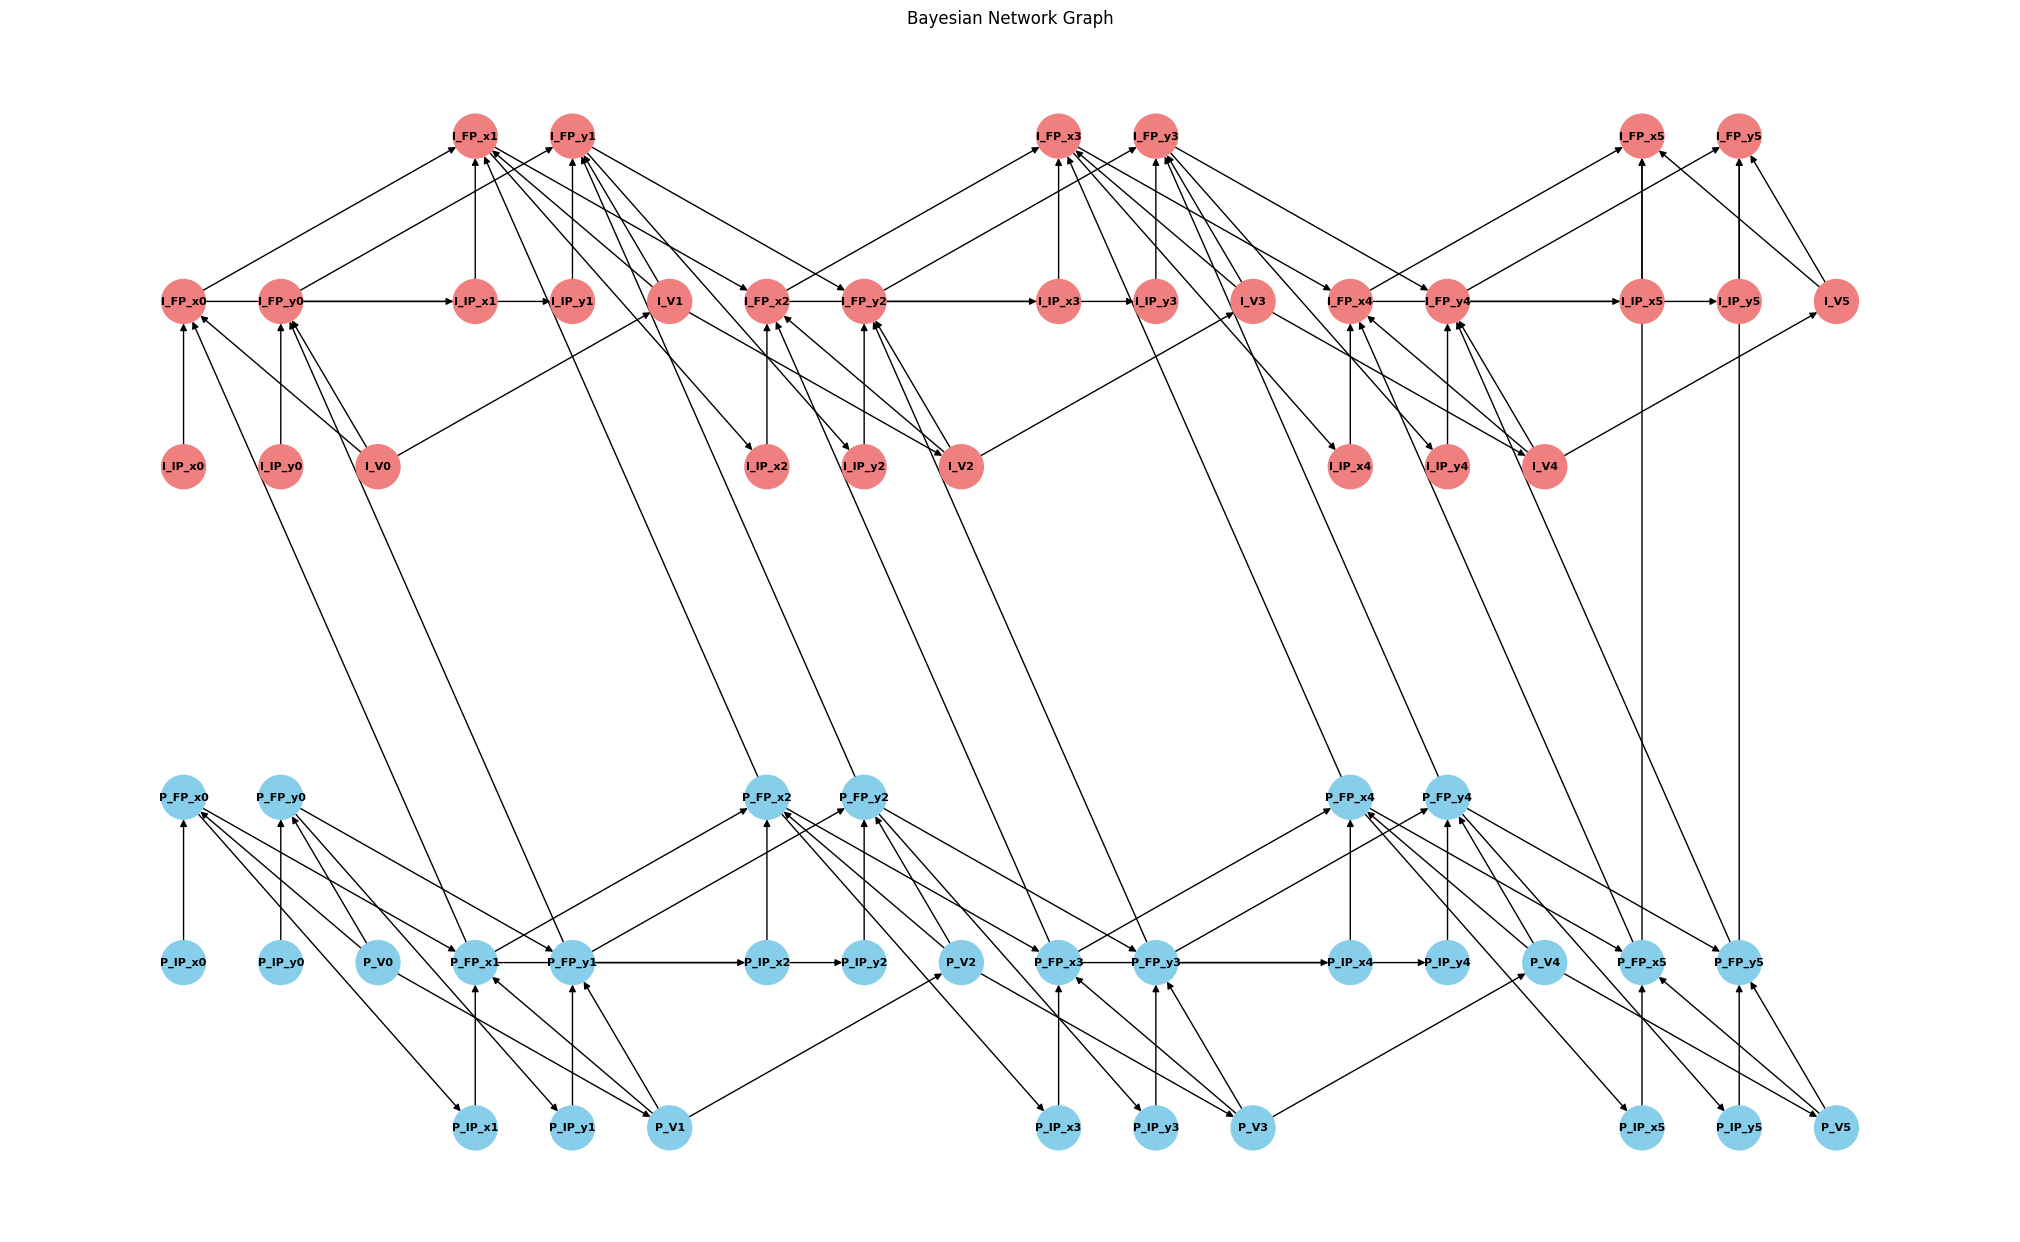

In [43]:
from pgmpy.factors.continuous import LinearGaussianCPD
from pgmpy.models import LinearGaussianBayesianNetwork

# Initialize the Bayesian Network model
GT = LinearGaussianBayesianNetwork()

for i in range(6):
    # Add nodes for final position (FP), velocity (V), and initial position (IP)
    GT.add_nodes_from([
        f'P_FP_x{i}', f'P_FP_y{i}', f'P_V{i}', f'P_IP_x{i}', f'P_IP_y{i}',  # Projectile nodes
        f'I_FP_x{i}', f'I_FP_y{i}', f'I_V{i}', f'I_IP_x{i}', f'I_IP_y{i}'   # Interceptor nodes
    ])
    
    # Add edges within each time slice for both x and y positions
    GT.add_edges_from([
        (f'P_IP_x{i}', f'P_FP_x{i}'),  # Initial position (x) influences final position (x)
        (f'P_V{i}', f'P_FP_x{i}'),     # Velocity influences final position (x)
        (f'P_IP_y{i}', f'P_FP_y{i}'),  # Initial position (y) influences final position (y)
        (f'P_V{i}', f'P_FP_y{i}'),     # Velocity influences final position (y)
        
        (f'I_IP_x{i}', f'I_FP_x{i}'),  # Interceptor: Initial position (x) influences final position (x)
        (f'I_V{i}', f'I_FP_x{i}'),     # Velocity influences final position (x)
        (f'I_IP_y{i}', f'I_FP_y{i}'),  # Initial position (y) influences final position (y)
        (f'I_V{i}', f'I_FP_y{i}')      # Velocity influences final position (y)
    ])

    if i < 5:
        # Connect corresponding nodes between time slices for projectile and interceptor
        GT.add_edges_from([
            # Projectile time slice connections for x and y positions
            (f'P_FP_x{i}', f'P_FP_x{i + 1}'),
            (f'P_FP_x{i}', f'P_IP_x{i + 1}'),
            (f'P_FP_y{i}', f'P_FP_y{i + 1}'),
            (f'P_FP_y{i}', f'P_IP_y{i + 1}'),
            (f'P_V{i}', f'P_V{i + 1}'),

            # Interceptor time slice connections for x and y positions
            (f'I_FP_x{i}', f'I_FP_x{i + 1}'),
            (f'I_FP_x{i}', f'I_IP_x{i + 1}'),
            (f'I_FP_y{i}', f'I_FP_y{i + 1}'),
            (f'I_FP_y{i}', f'I_IP_y{i + 1}'),
            (f'I_V{i}', f'I_V{i + 1}')
        ])
        
        # Edge between projectile and interceptor across time slices
        GT.add_edges_from([
            (f'P_FP_x{i + 1}', f'I_FP_x{i}'),
            (f'P_FP_y{i + 1}', f'I_FP_y{i}')
        ])

# Final edges to ensure convergence at the last time slice
GT.add_edges_from([
    (f'P_FP_x{5}', f'I_FP_x{5}'),
    (f'P_FP_y{5}', f'I_FP_y{5}')
])

# Visualize the updated Bayesian Network structure
visualise(GT, pos)




In [44]:
def fit_cpd_for_node(node, parents, data):
    required_columns = [node] + parents

    # Ensure all required columns are in the data
    missing_columns = [col for col in required_columns if col not in data.columns]
    if missing_columns:
        raise KeyError(f"Missing columns in data: {missing_columns}")
    
    # Creating the correct column names and structure for fitting
    node_data_before = data[required_columns].copy()
    node_data_before.columns = ["(Y|X)" if col == node else col for col in node_data_before.columns]

    # Add noise to all 0.0 values in the DataFrame
    noise_std = 1e-5 
    node_data = node_data_before.applymap(lambda x: x + np.random.normal(0, noise_std) if x == 0.0 else x)

    print("Fitting CPD for node:", node)
    print("Parents:", parents)
    print("Data being used for fit:")
    print(node_data.head())  # Print the first few rows of node_data

    if parents:
        # Initialize a Linear Gaussian CPD object
        cpd = LinearGaussianCPD(
            variable=node,
            evidence_mean=[0] * (len(parents) + 1),  # Initial guess for betas
            evidence_variance=1,  # Initial variance guess
            evidence=parents
        )
        
        node = "(Y|X)"
        print(f"Node: {node} \n")
        print("-"*50)
        # Fit the CPD using MLE
        beta, variance = cpd.fit(node_data, states=[node] + parents, estimator="MLE")
        return cpd
    else:
        # If no parents, fit a univariate Gaussian
        mean = data[node].mean()
        variance = data[node].var()
        return LinearGaussianCPD(variable=node, evidence_mean=[mean], evidence_variance=variance)




data = pd.read_csv('trajectory_data.csv')

# Assuming you have a pandas DataFrame `data` with all necessary columns.
for i in range(6):
    if i == 0:
        # Fit Projectile CPDs for x and y positions
        cpd_P_FP_x = fit_cpd_for_node(f'P_FP_x{i}', [f'P_V{i}', f'P_IP_x{i}'], data)
        cpd_P_FP_y = fit_cpd_for_node(f'P_FP_y{i}', [f'P_V{i}', f'P_IP_y{i}'], data)
        cpd_P_V = fit_cpd_for_node(f'P_V{i}', [], data)
        cpd_P_IP_x = fit_cpd_for_node(f'P_IP_x{i}', [], data)
        cpd_P_IP_y = fit_cpd_for_node(f'P_IP_y{i}', [], data)
    else:
        # Fit Projectile CPDs for x and y positions
        cpd_P_FP_x = fit_cpd_for_node(f'P_FP_x{i}', [f'P_V{i}', f'P_FP_x{i - 1}', f'P_IP_x{i}'], data)
        cpd_P_FP_y = fit_cpd_for_node(f'P_FP_y{i}', [f'P_V{i}', f'P_FP_y{i - 1}', f'P_IP_y{i}'], data)
        cpd_P_V = fit_cpd_for_node(f'P_V{i}', [f'P_V{i - 1}'], data)
        cpd_P_IP_x = fit_cpd_for_node(f'P_IP_x{i}', [f'P_FP_x{i - 1}'], data)
        cpd_P_IP_y = fit_cpd_for_node(f'P_IP_y{i}', [f'P_FP_y{i - 1}'], data)

    # Add fitted CPDs to the network
    GT.add_cpds(cpd_P_FP_x, cpd_P_FP_y, cpd_P_V, cpd_P_IP_x, cpd_P_IP_y)

# Fit and add Interceptor CPDs
for i in range(6):
    if i == 0:
        cpd_I_FP_x = fit_cpd_for_node(f'I_FP_x{i}', [f'P_FP_x{i+1}', f'I_IP_x{i}', f'I_V{i}'], data)
        cpd_I_FP_y = fit_cpd_for_node(f'I_FP_y{i}', [f'P_FP_y{i+1}', f'I_IP_y{i}', f'I_V{i}'], data)
        cpd_I_V = fit_cpd_for_node(f'I_V{i}', [], data)
        cpd_I_IP_x = fit_cpd_for_node(f'I_IP_x{i}', [], data)
        cpd_I_IP_y = fit_cpd_for_node(f'I_IP_y{i}', [], data)
    else:
        if i < 4:
            cpd_I_FP_x = fit_cpd_for_node(f'I_FP_x{i}', [f'P_FP_x{i+1}', f'I_IP_x{i}', f'I_V{i}', f'I_FP_x{i - 1}'], data)
            cpd_I_FP_y = fit_cpd_for_node(f'I_FP_y{i}', [f'P_FP_y{i+1}', f'I_IP_y{i}', f'I_V{i}', f'I_FP_y{i - 1}'], data)
        elif i < 5:
            cpd_I_FP_x = fit_cpd_for_node(f'I_FP_x{i}', [f'P_FP_x{i+1}', f'I_FP_x{i - 1}', f'I_IP_x{i}', f'I_V{i}'], data)
            cpd_I_FP_y = fit_cpd_for_node(f'I_FP_y{i}', [f'P_FP_y{i+1}', f'I_FP_y{i - 1}', f'I_IP_y{i}', f'I_V{i}'], data)
        else:
            cpd_I_FP_x = fit_cpd_for_node(f'I_FP_x{i}', [f'I_FP_x{i - 1}', f'I_IP_x{i}', f'I_V{i}', f'P_FP_x{i}'], data)
            cpd_I_FP_y = fit_cpd_for_node(f'I_FP_y{i}', [f'I_FP_y{i - 1}', f'I_IP_y{i}', f'I_V{i}', f'P_FP_y{i}'], data)

        cpd_I_V = fit_cpd_for_node(f'I_V{i}', [f'I_V{i - 1}'], data)
        cpd_I_IP_x = fit_cpd_for_node(f'I_IP_x{i}', [f'I_FP_x{i - 1}'], data)
        cpd_I_IP_y = fit_cpd_for_node(f'I_IP_y{i}', [f'I_FP_y{i - 1}'], data)

    # Add fitted CPDs to the network
    GT.add_cpds(cpd_I_FP_x, cpd_I_FP_y, cpd_I_V, cpd_I_IP_x, cpd_I_IP_y)



Fitting CPD for node: P_FP_x0
Parents: ['P_V0', 'P_IP_x0']
Data being used for fit:
         (Y|X)       P_V0       P_IP_x0
0  8003.468495  19.247998  10001.390531
1  8031.431621  17.004545  10037.722214
2  8254.093305  17.161721  10317.238512
3  7798.656714  17.790354   9745.781125
4  8147.148816  22.116195  10177.988303
Node: (Y|X) 

--------------------------------------------------
Fitting CPD for node: P_FP_y0
Parents: ['P_V0', 'P_IP_y0']
Data being used for fit:
      (Y|X)       P_V0   P_IP_y0
0  4.082466  19.247998 -0.000017
1  3.879587  17.004545 -0.000009
2  2.133319  17.161721  0.000015
3 -0.967582  17.790354 -0.000011
4  3.032582  22.116195  0.000003
Node: (Y|X) 

--------------------------------------------------
Fitting CPD for node: P_V0
Parents: []
Data being used for fit:
       (Y|X)
0  19.247998
1  17.004545
2  17.161721
3  17.790354
4  22.116195
Fitting CPD for node: P_IP_x0
Parents: []
Data being used for fit:
          (Y|X)
0  10001.390531
1  10037.722214
2  1031

In [45]:
# Validation
if GT.check_model():
    print("The model is valid!")
else:
    print("The model is not valid. Please check the CPDs and network structure.")


The model is valid!


In [46]:
import pandas as pd
from pgmpy.inference import VariableElimination, ApproxInference

# Load the test data
test_data = pd.read_csv("trajectory_test_data.csv")

import numpy as np

def predict_with_linear_gaussian_cpd(evidence, cpd):
    """
    Predict values using a Linear Gaussian CPD.
    
    Parameters
    ----------
    evidence: dict
        Dictionary with observed values.
    cpd: LinearGaussianCPD
        The CPD object to use for prediction.
    
    Returns
    -------
    dict
        Predicted values for the query variables.
    """
    # Extract the means and variances from the CPD
    beta = cpd.beta
    mean_vector = cpd.mean
    variance = cpd.variance
    # Calculate the predicted mean
    predicted_mean = mean_vector[0] + np.dot(
        [evidence[var] for var in cpd.evidence],
        beta[1:]
    )
    
    return predicted_mean

# List to store predictions for each row in test_data
predictions = []

# Iterate through each row in the test_data DataFrame
for index, row in test_data.iterrows():
    # Define the evidence for the current row
    evidence = {
        'P_IP_x0' : row['P_IP_x0'],   
        'P_V0'    : row['P_V0'],   
        'P_FP_x0' : row['P_FP_x0'],   
        'P_IP_y0' : row['P_IP_y0'],   
        'P_FP_y0' : row['P_FP_y0'],   
        'I_IP_x0' : row['I_IP_x0'],   
        'I_V0'    : row['I_V0'],   
        'P_IP_x1' : row['P_IP_x1'],   
        'P_V1'    : row['P_V1'],   
        'P_FP_x1' : row['P_FP_x1'],   
        'I_FP_x0' : row['I_FP_x0'],   
        'I_IP_y0' : row['I_IP_y0'],
        'P_IP_y1' : row['P_IP_y1'],
        'P_FP_y1' : row['P_FP_y1'],
        'I_FP_y0' : row['I_FP_y0'],
        'I_IP_x1' : row['I_IP_x1'],
        'I_V1'    : row['I_V1'],
        'P_IP_x2' : row['P_IP_x2'],
        'P_V2'    : row['P_V2'],
        'P_FP_x2' : row['P_FP_x2'],
        'I_FP_x1' : row['I_FP_x1'],
        'I_IP_y1' : row['I_IP_y1'],
        'P_IP_y2' : row['P_IP_y2'],
        'P_FP_y2' : row['P_FP_y2'],
        'I_FP_y1' : row['I_FP_y1'],
        'I_IP_x2' : row['I_IP_x2'],
        'I_V2'    : row['I_V2'],
        'P_IP_x3' : row['P_IP_x3'],
        'P_V3'    : row['P_V3'],
        'P_FP_x3' : row['P_FP_x3'],
        'I_FP_x2' : row['I_FP_x2'],
        'I_IP_y2' : row['I_IP_y2'],
        'P_IP_y3' : row['P_IP_y3'],
        'P_FP_y3' : row['P_FP_y3'],
        'I_FP_y2' : row['I_FP_y2'],
        'I_IP_x3' : row['I_IP_x3'],
        'I_V3'    : row['I_V3'],
        'P_IP_x4' : row['P_IP_x4'],
        'P_V4'    : row['P_V4'],
        'P_FP_x4' : row['P_FP_x4'],
        'I_FP_x3' : row['I_FP_x3'],
        'I_IP_y3' : row['I_IP_y3'],
        'P_IP_y4' : row['P_IP_y4'],
        'P_FP_y4' : row['P_FP_y4'],
        'I_FP_y3' : row['I_FP_y3'],
        'I_IP_x4' : row['I_IP_x4'],
        'I_V4'    : row['I_V4'],
        'P_IP_x5' : row['P_IP_x5'],
        'P_V5'    : row['P_V5'],
        'P_FP_x5' : row['P_FP_x5'],
        'I_FP_x4' : row['I_FP_x4'],
        'I_IP_y4' : row['I_IP_y4'],
        'P_IP_y5' : row['P_IP_y5'],
        'P_FP_y5' : row['P_FP_y5'],
        'I_FP_y4' : row['I_FP_y4'],
        'I_IP_x5' : row['I_IP_x5'],
        'I_V5'    : row['I_V5'],
        'I_FP_x5' : row['I_FP_x5'],
        'I_IP_y5' : row['I_IP_y5'],
        'I_FP_y5' : row['I_FP_y5']

    }
    
   
    cpd_x = GT.get_cpds('P_FP_x5')
    cpd_y = GT.get_cpds('P_FP_y5')
    
    # Predict future positions
    prediction_x = predict_with_linear_gaussian_cpd(evidence, cpd_x)
    prediction_y = predict_with_linear_gaussian_cpd(evidence, cpd_y)

    # Store the prediction results
    predictions.append({'P_FP_x5': prediction_x, 'P_FP_y5': prediction_y})

# Convert predictions to a DataFrame for easier analysis
predictions_df = pd.DataFrame(predictions)

# Print the prediction results
print(predictions_df)


         P_FP_x5     P_FP_y5
0    5486.354893  181.944069
1    5416.393747  159.260543
2    5562.802840  193.463885
3    5373.011516  194.267345
4    5422.030992  169.970210
..           ...         ...
995  5289.077374  182.243173
996  5434.312222  196.840637
997  5508.659019  188.179451
998  5467.378705  176.480909
999  5448.160528  191.111165

[1000 rows x 2 columns]


In [47]:
import pandas as pd
import numpy as np

# Load the test data
test_data = pd.read_csv("trajectory_test_data.csv")

def predict_with_linear_gaussian_cpd(evidence, cpd):
    """
    Predict values using a Linear Gaussian CPD.
    
    Parameters
    ----------
    evidence: dict
        Dictionary with observed values.
    cpd: LinearGaussianCPD
        The CPD object to use for prediction.
    
    Returns
    -------
    float
        Predicted value for the query variable.
    """
    beta = cpd.beta
    mean_vector = cpd.mean
    variance = cpd.variance
    # print(f"Evidence required: {cpd.evidence}")
    predicted_mean = mean_vector[0] + np.dot(
        [evidence[var] for var in cpd.evidence],
        beta[1:]
    )
    return predicted_mean

# List to store predictions for each row in test_data
predictions = []

# Iterate through each row in the test_data DataFrame
for index, row in test_data.iterrows():
    # Define initial evidence (time slice 0)
    evidence = {
        'P_IP_x0' : row['P_IP_x0'],   
        'P_V0'    : row['P_V0'],   
        'P_IP_y0' : row['P_IP_y0'],   
        'I_IP_x0' : row['I_IP_x0'],   
        'I_V0'    : row['I_V0'],   
        'I_IP_y0' : row['I_IP_y0'],
    }
    
    # Empty dict to store predictions for this row
    row_predictions = {}

    # COMPLETING PREDICTION FOR FIRST TREE

    cpd_x = GT.get_cpds(f'P_FP_x0')
    cpd_y = GT.get_cpds(f'P_FP_y0')
    
    prediction_x = predict_with_linear_gaussian_cpd(evidence, cpd_x)
    evidence[f'P_FP_x0'] = prediction_x

    prediction_y = predict_with_linear_gaussian_cpd(evidence, cpd_y)
    evidence[f'P_FP_y0'] = prediction_y
    
    row_predictions[f'P_FP_x0'] = prediction_x
    row_predictions[f'P_FP_y0'] = prediction_y
    
    # Propagate predictions for multiple time slices
    for t in range(1,6):
        # Predict for time slice t using evidence from time slice t-1
        cpd_v = GT.get_cpds(f'P_V{t}')
        cpd_I_x = GT.get_cpds(f'P_IP_x{t}')
        cpd_I_y = GT.get_cpds(f'P_IP_y{t}')
        cpd_x = GT.get_cpds(f'P_FP_x{t}')
        cpd_y = GT.get_cpds(f'P_FP_y{t}')
        
        prediction_v = predict_with_linear_gaussian_cpd(evidence, cpd_v)
        evidence[f'P_V{t}'] = prediction_v

        prediction_I_x = predict_with_linear_gaussian_cpd(evidence, cpd_I_x)
        evidence[f'P_IP_x{t}'] = prediction_I_x

        prediction_I_y = predict_with_linear_gaussian_cpd(evidence, cpd_I_y)
        evidence[f'P_IP_y{t}'] = prediction_I_y

        prediction_x = predict_with_linear_gaussian_cpd(evidence, cpd_x)
        evidence[f'P_FP_x{t}'] = prediction_x

        prediction_y = predict_with_linear_gaussian_cpd(evidence, cpd_y)
        evidence[f'P_FP_y{t}'] = prediction_y
        
        # Store the predictions for this time slice
        row_predictions[f'P_V{t}'] = prediction_v
        row_predictions[f'P_IP_x{t}'] = prediction_I_x
        row_predictions[f'P_IP_y{t}'] = prediction_I_y
        row_predictions[f'P_FP_x{t}'] = prediction_x
        row_predictions[f'P_FP_y{t}'] = prediction_y
        
        # Update the evidence with the new predictions to use in the next time slice
        
        
        # evidence[f'I_IP_x{t}'] = row[f'I_IP_x{t}']  # Assuming you also update interceptor evidence
        # evidence[f'I_IP_y{t}'] = row[f'I_IP_y{t}']
        # evidence[f'I_V{t}']    = row[f'I_V{t}']

    # Append predictions for this row
    predictions.append(row_predictions)

# Convert predictions to a DataFrame for easier analysis
predictions_df = pd.DataFrame(predictions)

# Print the prediction results
print(predictions_df)


         P_FP_x0   P_FP_y0       P_V1      P_IP_x1   P_IP_y1      P_FP_x1  \
0    8044.234496  2.017649  22.726617  9657.740932  2.676290  7409.925902   
1    7975.518791  1.561104  17.584136  9575.242284  2.070711  7344.178868   
2    8149.635719  2.095605  23.604702  9784.283452  2.779694  7507.303255   
3    7862.757175  2.192741  24.698832  9439.863028  2.908539  7243.988728   
4    7967.354979  1.756649  19.786732  9565.440980  2.330089  7337.760634   
..           ...       ...        ...          ...       ...          ...   
995  7761.354259  1.838923  20.713453  9318.120792  2.439220  7148.750509   
996  7950.882261  2.131406  24.007960  9545.664177  2.827181  7324.699643   
997  8079.243241  1.859237  20.942279  9699.771705  2.466166  7441.241794   
998  8024.277138  2.252920  25.376682  9633.780543  2.988362  7392.882095   
999  7978.270857  2.054290  23.139329  9578.546357  2.724891  7349.460245   

       P_FP_y1       P_V2      P_IP_x2    P_IP_y2  ...       P_V4  \
0    1

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create lists to store the actual and predicted values for comparison
actual_values = []
predicted_values = []

# Define the list of columns that we are interested in for comparison
columns_to_compare = [f'P_V{t}' for t in range(1,6)] + \
                     [f'P_IP_x{t}' for t in range(1,6)] + \
                     [f'P_IP_y{t}' for t in range(1,6)] + \
                     [f'P_FP_x{t}' for t in range(6)] + \
                     [f'P_FP_y{t}' for t in range(6)] 
                     

# Iterate over each row in the test data
for index, row in test_data.iterrows():
    actual_row = []
    predicted_row = []
    
    # Get actual values for the current row
    for col in columns_to_compare:
        actual_row.append(row[col])
    
    # Get predicted values for the current row from the predictions DataFrame
    predicted_row = [predictions_df.loc[index, col] for col in columns_to_compare]
    print("-" * 50 + "PREDICTED" + "-" * 50)
    print(predicted_row)
    print("-" * 50 + "ACTUAL" + "-" * 50)
    print(actual_row)

    actual_values.extend(actual_row)
    predicted_values.extend(predicted_row)

# Convert the lists to numpy arrays for metric calculation
actual_values = np.array(actual_values)
predicted_values = np.array(predicted_values)

# Calculate accuracy metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

--------------------------------------------------PREDICTED--------------------------------------------------
[22.726616844909262, 22.762810099807776, 22.85684695616131, 22.897463096952727, 22.99837823054122, 9657.740931838336, 8891.224537247459, 8185.330467342316, 7539.791912236335, 6955.9179777901845, 2.676290188770586, 13.265870783061935, 26.74434093828424, 40.06293904530793, 50.865282050104035, 8044.234495917586, 7409.925902191074, 6820.856032285009, 6284.931064676819, 5796.642589798843, 5344.496372493384, 2.0176494371097884, 13.119123479430087, 23.60659660552794, 33.17288067882049, 41.84681840831479, 50.028381222069434]
--------------------------------------------------PREDICTED--------------------------------------------------
[17.584136065275157, 17.61213966665251, 17.684898268980145, 17.716323964718164, 17.79440445739224, 9575.24228361332, 8812.334188114106, 8109.645735518696, 7467.054812704105, 6885.855716062919, 2.0707107947764944, 10.264126793072206, 20.692746889875952, 30.9